In [290]:
import numpy as np
import hasasia.sensitivity as sens
import hasasia.sim as sim
import matplotlib.pyplot as plt

import holodeck as holo
import holodeck.plot as plot
from holodeck.constants import YR

# 1)) Getting Started
### Create random PTA

In [291]:
phi = np.random.uniform(0, 2*np.pi, size=34)
theta = np.random.uniform(0, np.pi, size=34)
psrs = sim.sim_pta(timespan=11.4, cad=23, sigma=1e-7, 
                   phi=phi, theta=theta, Npsrs=34)
# timespan = dur/YR, cad = 1/(cad/YR). 
# This cad is number/yr. Holodeck cad is time b/t observations

### Make a spectra for each pulsar
Also calculate inverse-noise-weighted transmission function.

In [292]:
freqs = np.geomspace(5e-10, 5e-7, 400)
spectra = []
for psr in psrs: 
    spec = sens.Spectrum(psr, freqs=freqs)
    spec.NcalInv
    spectra.append(spec)
# without concern for NcalInv, could just do
# spectra = [sens.Spectrum(p, freqs=freqs) for p in psrs]

### Get sensitivity curves
Enter list of spectra into sensitivty curve classes.
- Deterministic (single source, averaged over inclination, polarization, and sky position) has effective strain-noise power spectral density $S_\mathrm{eff}(f) \equiv \big(\frac{4}{5} \sum_I \frac{T_I}{T_\mathrm{obs}} \frac{1}{S_I(f)} \big)^{-1} $   (70)
 
- GWB: level of GWB that would be required to produce the actual noise of the detector (non-Gaussian and non-stationary.) with $S_\mathrm{eff}(f) = \big(\sum_I \sum_J \frac{T_{IJ}}{ T_\mathrm{obs} \frac{\chi_{IJ}^2}{S_I(f)S_J^{f}}}  \big)^{-1/2} $   (89)

According to Hazboun (2019) both follow 
$ h_c(f) \equiv \sqrt{f S_\mathrm{eff}(f)} $    (72)

In [293]:
scGWB = sens.GWBSensitivityCurve(spectra)
scDeter = sens.DeterSensitivityCurve(spectra)

Plot sensitivity curves

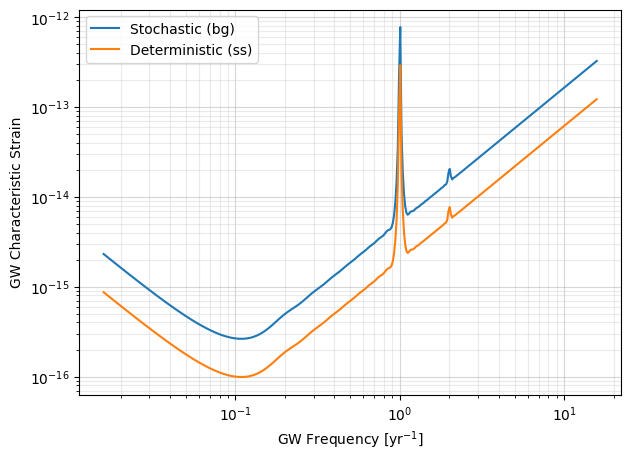

In [294]:
xx = freqs * YR
fig, ax = plot.figax(
    xlabel=plot.LABEL_GW_FREQUENCY_YR,
    ylabel=plot.LABEL_CHARACTERISTIC_STRAIN
)
ax.loglog(xx, scGWB.h_c, label='Stochastic (bg)')
ax.loglog(xx, scDeter.h_c, label='Deterministic (ss)')
ax.legend()

### Compare different PTA baseline

In [295]:
# same cad, signa, phi, theta, Npsrs. Just different timespan
psrs2 = sim.sim_pta(timespan=3.0, cad=23, sigma=1e-7, phi=phi, theta=theta, Npsrs=34)
spectra2 = [sens.Spectrum(psr, freqs=freqs) for psr in psrs2]
scGWB2 = sens.GWBSensitivityCurve(spectra2)
scDeter2 = sens.DeterSensitivityCurve(spectra2)

Plot, like in tutorial

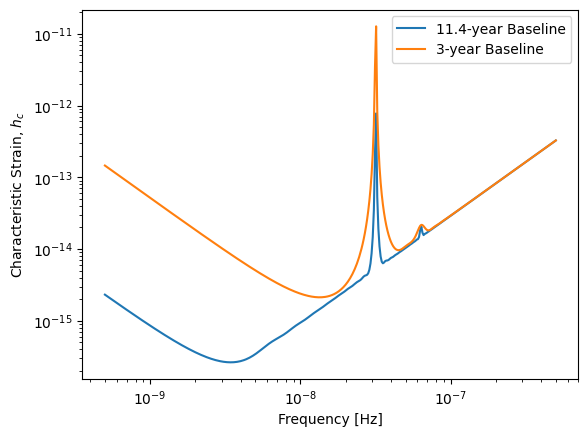

In [296]:
plt.loglog(freqs,scGWB.h_c,label='11.4-year Baseline')
plt.loglog(freqs,scGWB2.h_c,label='3-year Baseline')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.legend()
plt.show()

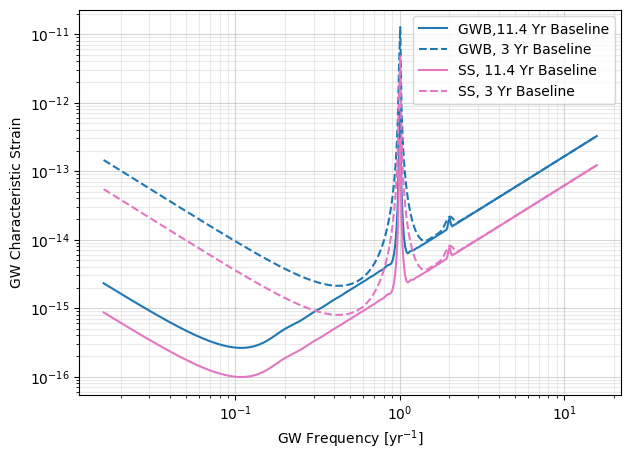

In [297]:
xx = freqs * YR
fig, ax = plot.figax(
    xlabel=plot.LABEL_GW_FREQUENCY_YR,
    ylabel=plot.LABEL_CHARACTERISTIC_STRAIN
)
ax.loglog(xx, scGWB.h_c, label='GWB,11.4 Yr Baseline', 
          color='C0')
ax.loglog(xx, scGWB2.h_c, label='GWB, 3 Yr Baseline', 
          color='C0', ls='dashed')
ax.loglog(xx, scDeter.h_c, label='SS, 11.4 Yr Baseline',
          color='tab:pink')
ax.loglog(xx, scDeter2.h_c, label='SS, 3 Yr Baseline',
          color='tab:pink', ls='dashed')
ax.legend()

# 2)) Sensitivity Tutorial

In [298]:
import hasasia.sim as hsim
import hasasia.sensitivity as hsen

## 2.1) Create PTA and Spectra
### Random PTA (list of sens.pulsar objects)

In [299]:
phi = np.random.uniform(0, 2*np.pi, size=34)
cos_theta = np.random.uniform(-1,1,size=34)
theta = np.arccos(cos_theta)
timespan=[11.4 for ii in range(10)] # first 10 pulsars have 11.4 yrs of data
timespan.extend([3.0 for ii in range(24)]) # last 24 pulsars have only 3 yrs of data
# timespan=np.empty_like(phi) # if I wanted to use numpy array instead
# for ii in range(len(phi)):
#     if ii<10: timespan[ii]=11.4
#     else: timespan[ii]=3.0
print(timespan)

[11.4, 11.4, 11.4, 11.4, 11.4, 11.4, 11.4, 11.4, 11.4, 11.4, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]


In [300]:
psrs_wo = hsim.sim_pta(timespan=timespan, cad=23, sigma=1e-7, 
                     phi=phi, theta=theta)

In [301]:
psrs = hsim.sim_pta(timespan=timespan, cad=23, sigma=1e-7,
                    phi=phi,theta=theta)

#### Include red noise (power law $A_\mathrm{RN} f^\alpha$) in a new PTA, this is the GWB

In [302]:
freqs = np.logspace(np.log10(5e-10), np.log10(5e-7),500)
psrs_rn = hsim.sim_pta(timespan=timespan,cad=23,sigma=1e-7,
                     phi=phi,theta=theta,
                     A_rn=6e-16, alpha=-2/3.,freqs=freqs)

In [303]:
psrs2 = hsim.sim_pta(timespan=timespan,cad=23,sigma=1e-7,
                     phi=phi,theta=theta,
                     A_rn=6e-16, alpha=-2/3.,freqs=freqs)

In [304]:
print(psrs[0].__dict__.keys())
print(np.all(psrs[20].toas == psrs_wo[20].toas))
print(np.all(psrs2[20].toaerrs == psrs_rn[20].toaerrs))

dict_keys(['toas', 'toaerrs', 'phi', 'theta', 'pdist', 'N', 'designmatrix'])
True
True


### Spectra for each pulsar

In [305]:
spectra_wo = []
for psr in psrs_wo:
    sp = hsen.Spectrum(psr, freqs=freqs)
    sp.NcalInv # inverse noise weighted transmission function
    spectra_wo.append(sp)

spectra_rn = []
for psr in psrs_rn:
    sp = hsen.Spectrum(psr, freqs=freqs)
    sp.NcalInv
    spectra_rn.append(sp)

In [306]:
spectra = []
for p in psrs:
    sp = hsen.Spectrum(p, freqs=freqs)
    sp.NcalInv
    spectra.append(sp)
spectra2 = []
for p in psrs2:
    sp = hsen.Spectrum(p, freqs=freqs)
    sp.NcalInv
    spectra2.append(sp)

In [307]:
print(spectra_wo[0].__dict__.keys())
# for spec in spectra1:
    # print(holo.utils.stats(spec.freqs)) # the freqs are same for all of them
    # print(holo.utils.stats(spec.NcalInv)) # same for all w/ same timespan
# print(np.all(sp == psrs_wo[20].toas))
print(np.all(spectra_wo[20]._NcalInv == spectra[20]._NcalInv))
print(np.all(spectra_rn[20]._NcalInv == spectra2[20]._NcalInv))

dict_keys(['_H_0', 'toas', 'toaerrs', 'phi', 'theta', 'N', 'designmatrix', 'pdist', 'tm_fit', 'Tf_kwargs', 'freqs', '_psd_prefit', '_NcalInv'])
True
True


#### NcalInv: 
Inverse noise-weighted transmission function, Eq. (19-20) in Hazboun et al. (2019).  Inverse of the detector's (noise power spectral density) x (frequency response function).

NcalInv is a property. Do you just name a property in order to calculate it, or why do we need to do that? Is it not calculated when first used internally?

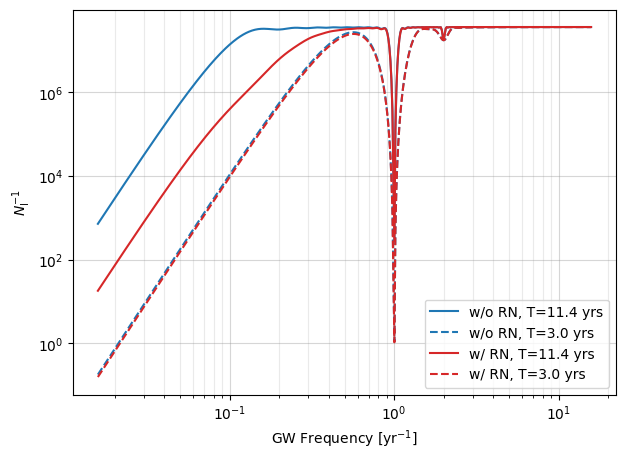

In [308]:
xx = freqs*YR
fig, ax = plot.figax(
    xlabel=plot.LABEL_GW_FREQUENCY_YR,
    ylabel='$N_\mathrm{I}^{-1}$'
)
ax.loglog(xx, spectra_wo[0].NcalInv, color='tab:blue',
          label='w/o RN, T={0} yrs'.format(timespan[0]))
ax.loglog(xx, spectra_wo[10].NcalInv, color='tab:blue', ls='--', 
          label='w/o RN, T={0} yrs'.format(timespan[10]))
ax.loglog(xx, spectra_rn[0].NcalInv, color='tab:red',
          label='w/ RN, T={0} yrs'.format(timespan[0]))
ax.loglog(xx, spectra_rn[10].NcalInv, color='tab:red', ls='--',
          label='w/ RN, T={0} yrs'.format(timespan[10]))
ax.legend()

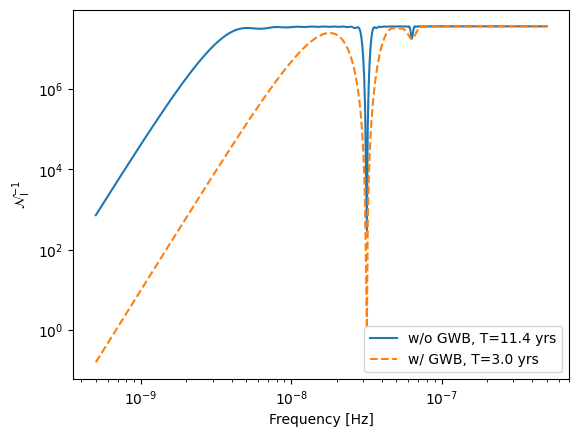

In [309]:
plt.loglog(spectra[0].freqs,spectra[0].NcalInv,
           label='w/o GWB, T={0} yrs'.format(timespan[0]))
plt.loglog(spectra2[20].freqs,spectra2[20].NcalInv,'--',
           label='w/ GWB, T={0} yrs'.format(timespan[20]))
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$\mathcal{N}^{-1}_{\rm I}$')
plt.legend()
plt.show()

#### S_I: Strain power sensitivity. Eq. (76)
$$ S_\mathrm{I} = \frac{1}{\cal{N}^{-1}\cal{R}}$$

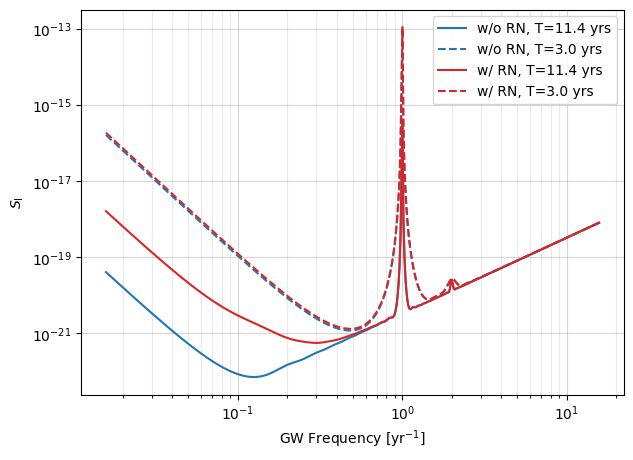

In [310]:
xx = freqs*YR
fig, ax = plot.figax(
    xlabel=plot.LABEL_GW_FREQUENCY_YR,
    ylabel='$S_\mathrm{I}$',
)
ax.loglog(xx, spectra_wo[0].S_I, color='tab:blue',
          label='w/o RN, T={0} yrs'.format(timespan[0]))
ax.loglog(xx, spectra_wo[10].S_I, color='tab:blue', ls='--',
          label='w/o RN, T={0} yrs'.format(timespan[10]))
ax.loglog(xx, spectra_rn[0].S_I, color='tab:red',
          label='w/ RN, T={0} yrs'.format(timespan[0]))
ax.loglog(xx, spectra_rn[10].S_I, color='tab:red', ls='--', 
          label='w/ RN, T={0} yrs'.format(timespan[10]))
ax.legend()

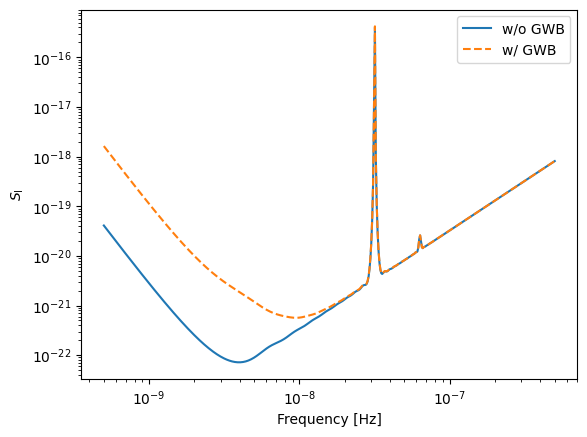

In [311]:
plt.loglog(spectra[0].freqs,spectra[0].S_I,label='w/o GWB')
plt.loglog(spectra2[0].freqs,spectra2[0].S_I,'--',label='w/ GWB')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$S_{\rm I}$')
plt.legend()
plt.show()

## 2.2) Sensitivity Curvess

In [312]:
sc1a = hsen.GWBSensitivityCurve(spectra)
sc1b = hsen.DeterSensitivityCurve(spectra)
sc2a = hsen.GWBSensitivityCurve(spectra2)
sc2b = hsen.DeterSensitivityCurve(spectra2)

In [313]:
sc_wo_bg = hsen.GWBSensitivityCurve(spectra_wo)
sc_wo_ss = hsen.DeterSensitivityCurve(spectra_wo)
sc_rn_bg = hsen.GWBSensitivityCurve(spectra_rn)
sc_rn_ss = hsen.DeterSensitivityCurve(spectra_rn)

Effective Strain Noise PSD $S_\mathrm{eff}$

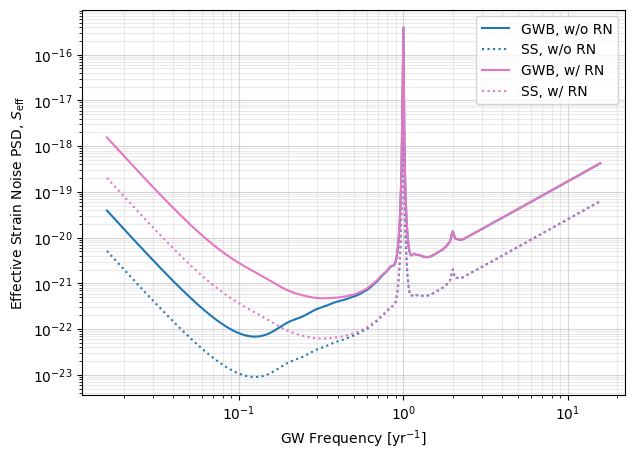

In [314]:
xx = freqs*YR
fig, ax = plot.figax(
    xlabel=plot.LABEL_GW_FREQUENCY_YR,
    ylabel='Effective Strain Noise PSD, $S_\mathrm{eff}$'
)
ax.loglog(xx, sc_wo_bg.S_eff, color='tab:blue',
          label='GWB, w/o RN')
ax.loglog(xx, sc_wo_ss.S_eff, color='tab:blue', ls=':',
          label='SS, w/o RN')
ax.loglog(xx, sc_rn_bg.S_eff, color='tab:pink',
          label='GWB, w/ RN')
ax.loglog(xx, sc_rn_ss.S_eff, color='tab:pink', ls=':', 
          label='SS, w/ RN')
ax.legend()

In [317]:
print(np.all(sc1a.S_eff == sc_wo_bg.S_eff))
print(np.all(sc1b.S_eff == sc_wo_ss.S_eff))
print(np.all(sc2a.S_eff == sc_rn_bg.S_eff))
print(np.all(sc2a.S_eff == sc_rn_ss.S_eff))

True
True
True
False


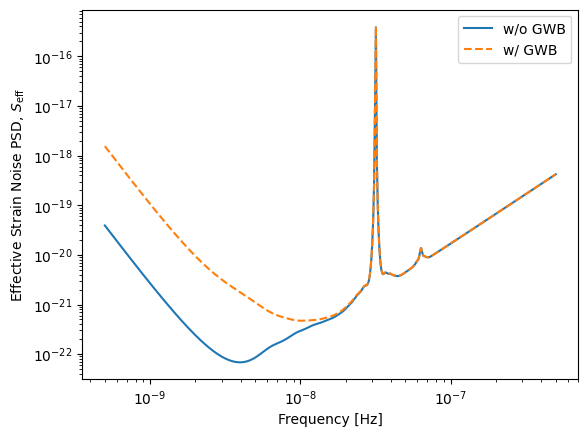

In [318]:
plt.loglog(sc1a.freqs,sc1a.S_eff,label='w/o GWB')
plt.loglog(sc2a.freqs,sc2a.S_eff,'--',label='w/ GWB')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Effective Strain Noise PSD, $S_{\rm eff}$')
plt.legend()
plt.show()

Characteristic Strain, $h_c$

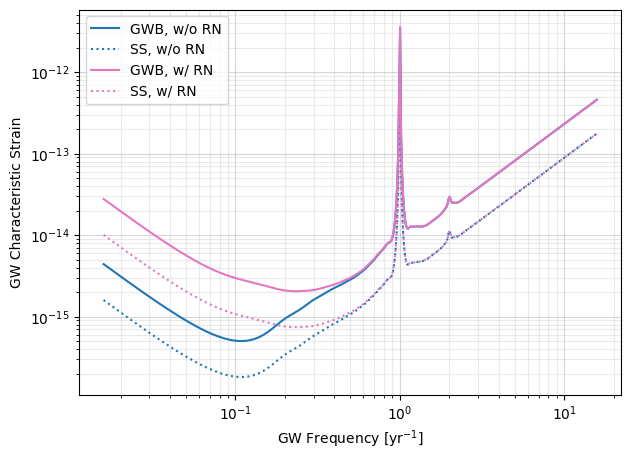

In [316]:
xx = freqs*YR
fig, ax = plot.figax(
    xlabel=plot.LABEL_GW_FREQUENCY_YR,
    ylabel=plot.LABEL_CHARACTERISTIC_STRAIN
)
ax.loglog(xx, sc_wo_bg.h_c, color='tab:blue',
          label='GWB, w/o RN')
ax.loglog(xx, sc_wo_ss.h_c, color='tab:blue', ls=':',
          label='SS, w/o RN')
ax.loglog(xx, sc_rn_bg.h_c, color='tab:pink',
          label='GWB, w/ RN')
ax.loglog(xx, sc_rn_ss.h_c, color='tab:pink', ls=':', 
          label='SS, w/ RN')
ax.legend()

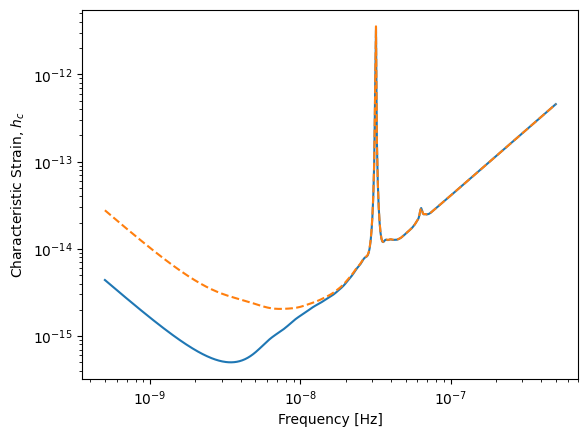

In [ ]:
plt.loglog(sc1a.freqs,sc1a.h_c)
plt.loglog(sc2a.freqs,sc2a.h_c,'--')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.show()

Energy Density, $\Omega_{gw}$

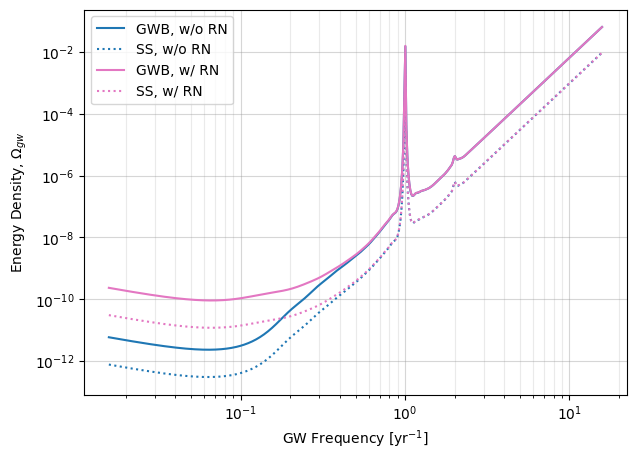

In [322]:
xx = freqs*YR
fig, ax = plot.figax(
    xlabel=plot.LABEL_GW_FREQUENCY_YR,
    ylabel='Energy Density, $\Omega_{gw}$'
)
ax.loglog(xx, sc_wo_bg.Omega_gw, color='tab:blue',
          label='GWB, w/o RN')
ax.loglog(xx, sc_wo_ss.Omega_gw, color='tab:blue', ls=':',
          label='SS, w/o RN')
ax.loglog(xx, sc_rn_bg.Omega_gw, color='tab:pink',
          label='GWB, w/ RN')
ax.loglog(xx, sc_rn_ss.Omega_gw, color='tab:pink', ls=':', 
          label='SS, w/ RN')
ax.legend()

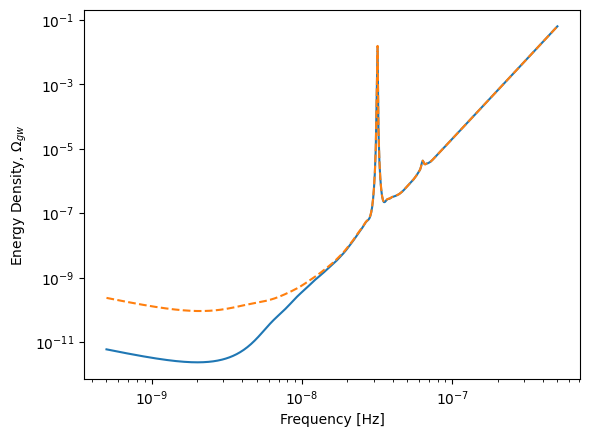

In [323]:
plt.loglog(sc1a.freqs,sc1a.Omega_gw)
plt.loglog(sc2a.freqs,sc2a.Omega_gw,'--')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Energy Density, $\Omega_{gw}$')
plt.show()


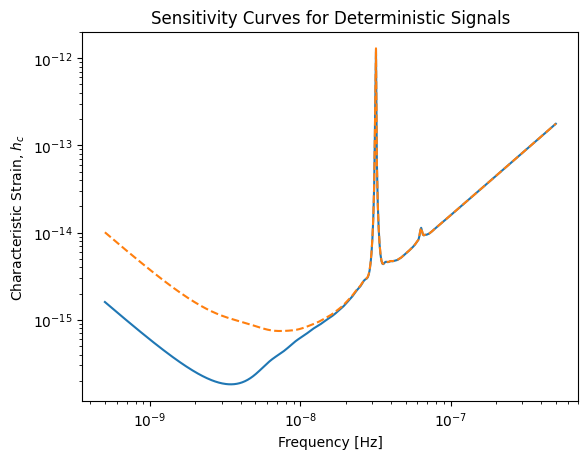

In [324]:
plt.loglog(sc1b.freqs,sc1b.h_c)
plt.loglog(sc2b.freqs,sc2b.h_c,'--')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.title('Sensitivity Curves for Deterministic Signals')
plt.show()

## 2.3) Multiple Red Noise Values
Can give each pulsar it's own red noise power spectrum

In [328]:
A_rn = np.random.uniform(1e-16,1e-12,size=phi.shape[0])
alphas = np.random.uniform(-3/4,1,size=phi.shape[0])

psrs_vr = hsim.sim_pta(timespan=timespan, cad=23, sigma=1e-7,
                       phi=phi, theta=theta, 
                       A_rn=A_rn, alpha=alphas, freqs=freqs)
spectra_vr = []
for psr in psrs_vr:
    sp = hsen.Spectrum(psr, freqs=freqs)
    sp.NcalInv
    spectra_vr.append(sp)

sc_vr_bg = hsen.GWBSensitivityCurve(spectra_vr)
sc_vr_ss = hsen.DeterSensitivityCurve(spectra_vr)

In [329]:
psrs3 = hsim.sim_pta(timespan=timespan,cad=23,sigma=1e-7,
                     phi=phi,theta=theta,
                     A_rn=A_rn,alpha=alphas,freqs=freqs)

spectra3 = []
for p in psrs3:
    sp = hsen.Spectrum(p, freqs=freqs)
    sp.NcalInv
    spectra3.append(sp)

sc3a=hsen.GWBSensitivityCurve(spectra3)
sc3b=hsen.DeterSensitivityCurve(spectra3)


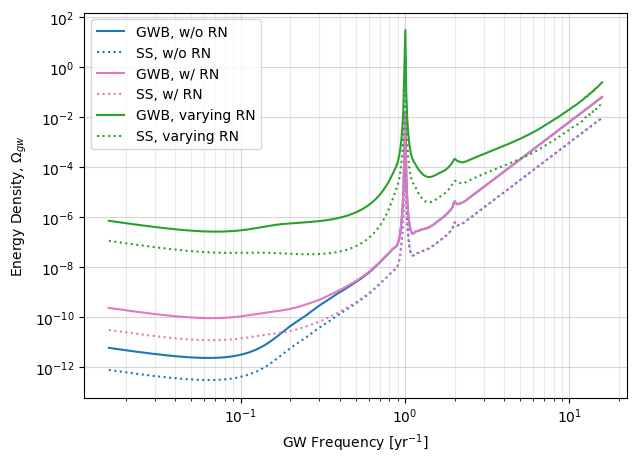

In [330]:
xx = freqs*YR
fig, ax = plot.figax(
    xlabel=plot.LABEL_GW_FREQUENCY_YR,
    ylabel='Energy Density, $\Omega_{gw}$'
)
ax.loglog(xx, sc_wo_bg.Omega_gw, color='tab:blue',
          label='GWB, w/o RN')
ax.loglog(xx, sc_wo_ss.Omega_gw, color='tab:blue', ls=':',
          label='SS, w/o RN')
ax.loglog(xx, sc_rn_bg.Omega_gw, color='tab:pink',
          label='GWB, w/ RN')
ax.loglog(xx, sc_rn_ss.Omega_gw, color='tab:pink', ls=':', 
          label='SS, w/ RN')
ax.loglog(xx, sc_vr_bg.Omega_gw, color='tab:green',
          label='GWB, varying RN')
ax.loglog(xx, sc_vr_ss.Omega_gw, color='tab:green', ls=':', 
          label='SS, varying RN')
ax.legend()

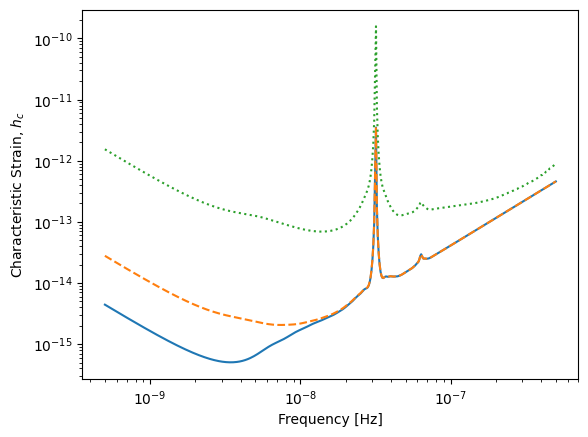

In [331]:
plt.loglog(sc1a.freqs,sc1a.h_c)
plt.loglog(sc2a.freqs,sc2a.h_c,'--')
plt.loglog(sc3a.freqs,sc3a.h_c,':')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.show()

## 2.4) Power Law-Integrated Sensitivity Curve
Calculate amplitude of a GWB needed to obtain a particular SNR w/ the default spectral index

In [355]:
yr_sec = 365.25*24*3600
fyr = 1/yr_sec

In [360]:
# Here is how PI_hc calculates the power-law integrated strain
# First it gets the amplitude, h 
N=30 # number of dif alphas to use
alpha = np.linspace(-1.75, 1.25, N)
h = hsen.Agwb_from_Seff_plaw(freqs=sc_wo_bg.freqs, Tspan=sc_wo_bg.Tspan,
                             SNR=3, S_eff=sc_wo_bg.S_eff, alpha=alpha) # get's an amplitude 
plaw = np.dot((freqs[:,np.newaxis]/fyr)**alpha,h[:,np.newaxis]*np.eye(N))

PI_sensitivity = np.amax(plaw, axis=1)
print(h.shape, plaw.shape, PI_sensitivity.shape)

(30,) (500, 30) (500,)


In [351]:
hgw = hsen.Agwb_from_Seff_plaw(sc1a.freqs, Tspan=sc1a.Tspan, SNR=3,
                               S_eff=sc1a.S_eff)

#We calculate the power law across the frequency range for plotting.
fyr = 1/(365.25*24*3600)
plaw_h = hgw*(sc1a.freqs/fyr)**(-2/3)

In [352]:
PI_sc, plaw = hsen.PI_hc(freqs=sc1a.freqs, Tspan=sc1a.Tspan,
                         SNR=3, S_eff=sc1a.S_eff, N=30)

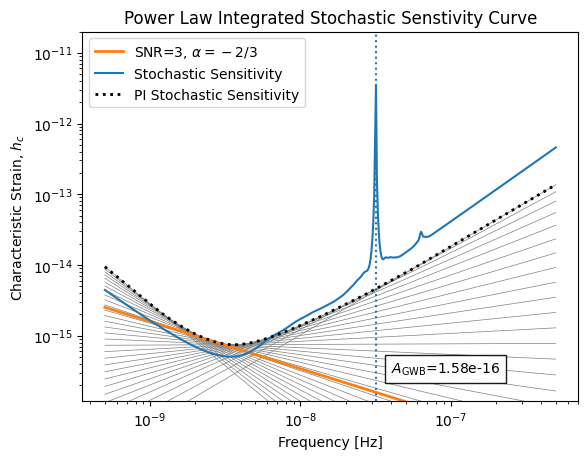

In [336]:
for ii in range(plaw.shape[1]):
    plt.loglog(sc1a.freqs,plaw[:,ii],
               color='gray',lw=0.5)
plt.loglog(sc1a.freqs,plaw_h,color='C1',lw=2,
           label=r'SNR=3, $\alpha=-2/3$')
plt.loglog(sc1a.freqs,sc1a.h_c, label='Stochastic Sensitivity')
plt.loglog(sc1a.freqs,PI_sc, linestyle=':',color='k',lw=2,
           label='PI Stochastic Sensitivity')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.axvline(fyr,linestyle=':')
plt.title('Power Law Integrated Stochastic Senstivity Curve')
plt.ylim(hgw*0.75,2e-11)
plt.text(x=4e-8,y=3e-16,
         s=r'$A_{\rm GWB}$='+'{0:1.2e}'.format(hgw),
         bbox=dict(facecolor='white', alpha=0.9))
plt.legend(loc='upper left')
plt.show()

## 2.5) Pairwise Sensitivity Curves

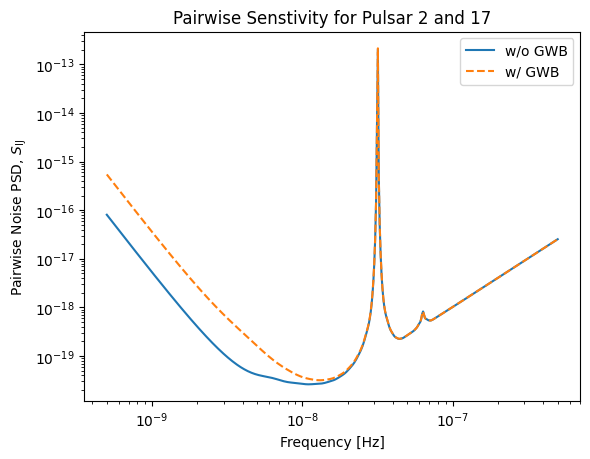

In [361]:
plt.loglog(sc1a.freqs,sc1a.S_effIJ[79],label='w/o GWB')
plt.loglog(sc2a.freqs,sc2a.S_effIJ[79],'--',label='w/ GWB')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Pairwise Noise PSD, $S_{\rm IJ}$')
p1,p2 = sc1a.pairs[:,79]
plt.title(r'Pairwise Senstivity for Pulsar {0} and {1}'.format(p1,p2))
plt.legend()
plt.show()

# 3)) SkySensitivity Tutorial

In [368]:
import healpy as hp
import astropy.units as u
import astropy.constants as c
import hasasia.skymap as hsky

## 3.1) Make PTA

In [369]:
#Make a set of random sky positions
phi = np.random.uniform(0, 2*np.pi,size=33)
cos_theta = np.random.uniform(-1,1,size=33)
theta = np.arccos(cos_theta)

#Adding one well-placed sky position for plots.
phi = np.append(np.array(np.deg2rad(60)),phi)
theta = np.append(np.array(np.deg2rad(50)),theta)

#Define the timsespans and TOA errors for the pulsars
timespans = np.random.uniform(3.0,11.4,size=34)
Tspan = timespans.max()*365.25*24*3600
sigma = 1e-7 # 100 ns
print(Tspan/YR)

11.389032860285006


In [370]:
#Simulate a set of identical pulsars, with different sky positions.
psrs = hsim.sim_pta(timespan=11.4, cad=23, sigma=sigma,
                    phi=phi, theta=theta)

In [371]:
freqs = np.logspace(np.log10(1/(5*Tspan)),np.log10(2e-7),500)
spectra = []
for p in psrs:
    sp = hsen.Spectrum(p, freqs=freqs)
    sp.NcalInv
    spectra.append(sp)

## 3.2) SkySensitivity Object

In [372]:
#Use the healpy functions to get the sky coordinates
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [373]:
SM=hsky.SkySensitivity(spectra,theta_gw, phi_gw)

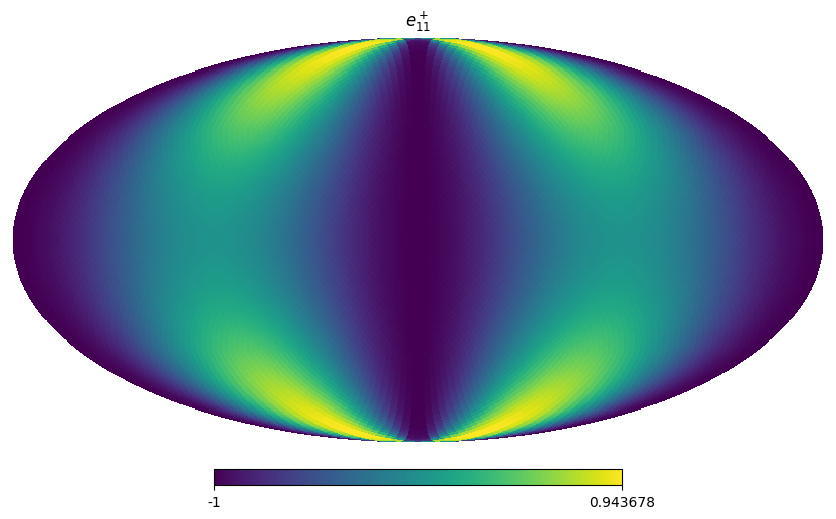

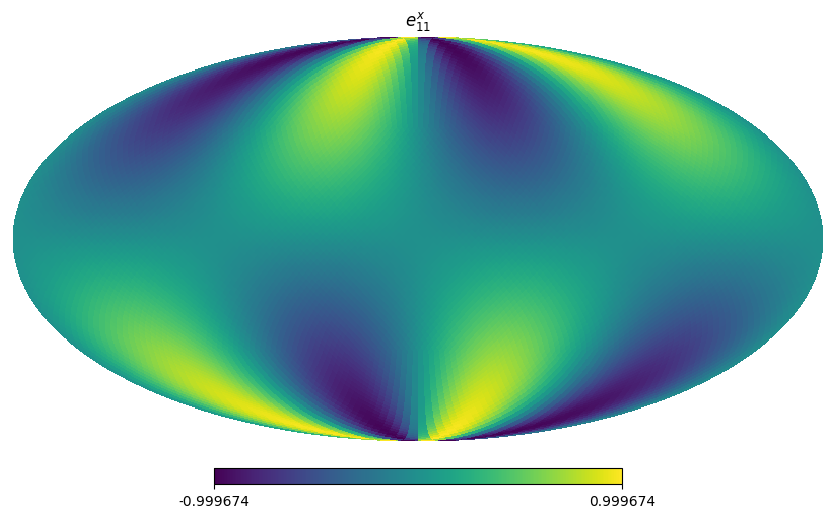

In [378]:
hp.mollview(SM.eplus[1,1,:], title='$e_{11}^+$',)
hp.mollview(SM.ecross[1,1,:], title='$e_{11}^x$',)

response function of individual pulsars

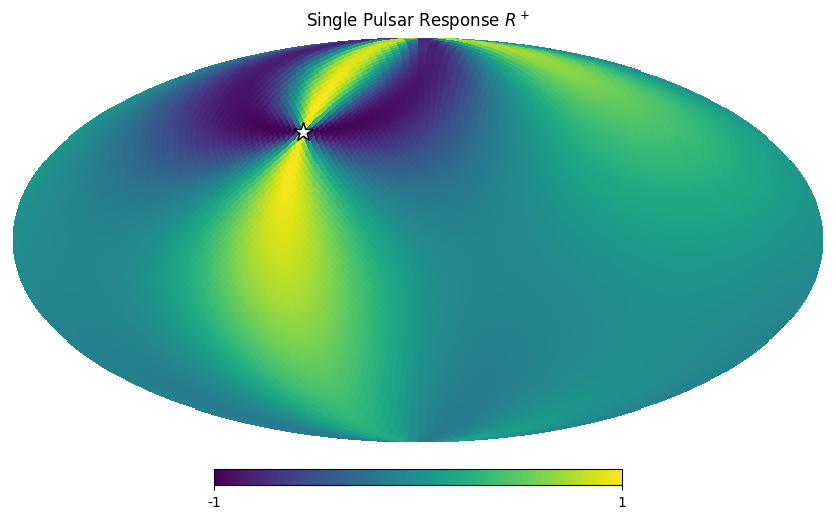

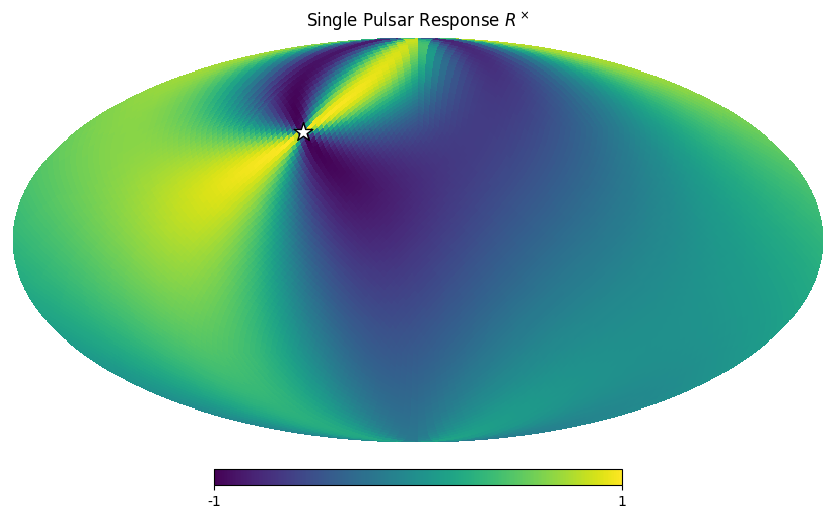

In [376]:
idx = 0
hp.mollview(SM.Fplus[idx], fig=1,
            title="Single Pulsar Response $R^+$",min=-1,max=1)
hp.visufunc.projscatter(SM.thetas[idx],SM.phis[idx],
                        marker='*',color='white',
                        edgecolors='k',s=200)
hp.mollview(SM.Fcross[idx], fig=2,
            title=r"Single Pulsar Response $R^\times$",min=-1,max=1)
hp.visufunc.projscatter(SM.thetas[idx],SM.phis[idx],
                        marker='*',color='white',
                        edgecolors='k',s=200)

plt.show()


full residual response

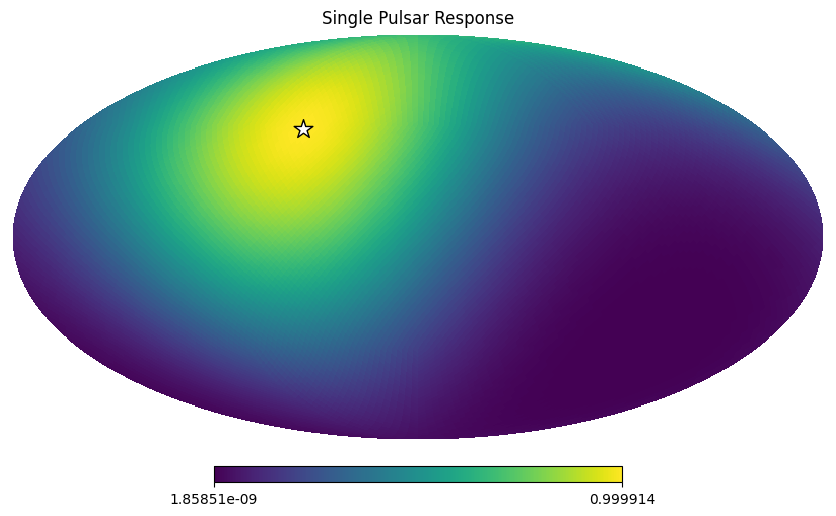

In [379]:
idx =0
hp.mollview(SM.sky_response[idx], title="Single Pulsar Response")
hp.visufunc.projscatter(SM.thetas[idx], SM.phis[idx],
                        marker='*',color='white',
                        edgecolors='k',s=200)
plt.show()

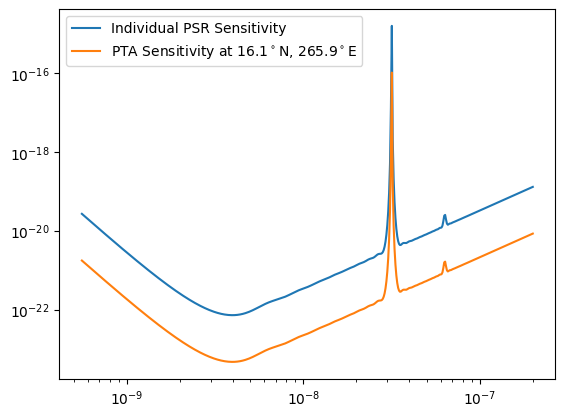

In [380]:
sky_loc = 'PTA Sensitivity at '
sky_loc += '{0:2.1f}$^\circ$N, {1:2.1f}$^\circ$E'.format(np.rad2deg(theta_gw[252]),
                                               np.rad2deg(phi_gw[252]))
plt.loglog(SM.freqs,spectra[0].S_I, label='Individual PSR Sensitivity')
plt.loglog(SM.freqs,SM.S_effSky[:,252],
           label=sky_loc)
plt.legend(loc='upper left')
plt.show()

Sensitivity across sky

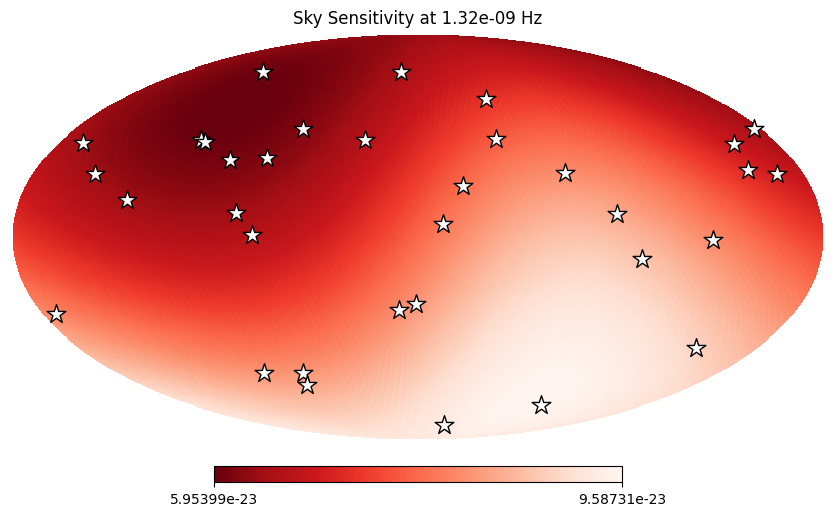

In [381]:
idx = 73
hp.mollview(SM.S_effSky[idx],
            title="Sky Sensitivity at {0:2.2e} Hz".format(SM.freqs[idx]),
            cmap='Reds_r')
hp.visufunc.projscatter(SM.thetas,SM.phis,
                        marker='*',color='white',
                        edgecolors='k',s=200)
plt.show()

## 3.3) Signal SNR across the Sky
SNR for a given signal at every sky position

In [384]:
# for circular binaries
hCirc = hsky.h_circ(1e9,200,5e-9,Tspan,SM.freqs).to('')

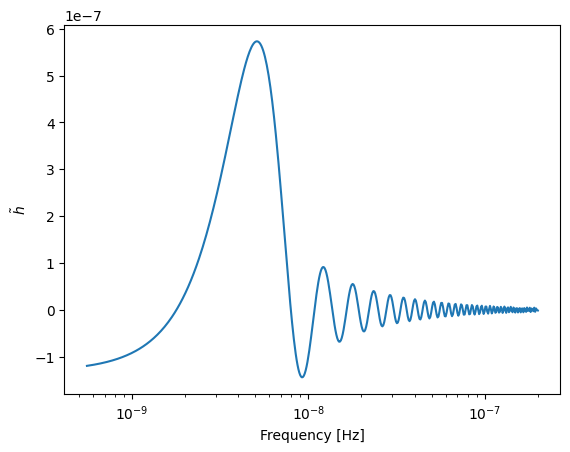

In [385]:
# plot signal in frequency domain for a finite integration time
plt.semilogx(SM.freqs, hCirc)
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$\tilde{h}$')
plt.show()

In [386]:
SNR = SM.SNR(hCirc.value[167])

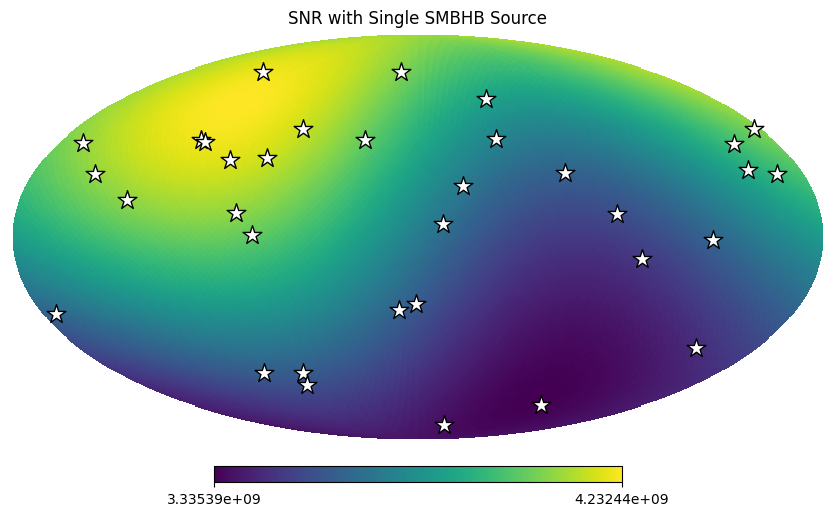

In [387]:
idx = 167
hp.mollview(SNR[idx],
            title="SNR with Single SMBHB Source",
            cmap='viridis')
hp.visufunc.projscatter(SM.thetas,SM.phis,marker='*',
                        color='white',edgecolors='k',s=200)
plt.show()

In [388]:
h_divA = (hsky.h_circ(1e9,200,5e-9,Tspan,SM.freqs)
          /hsky.h0_circ(1e9,200,5e-9)).value

In [389]:
Amp = SM.A_gwb(h_divA)


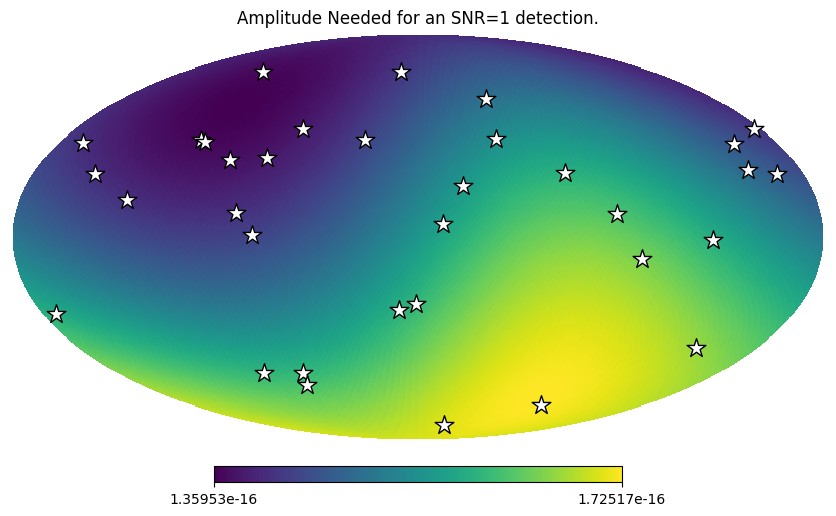

In [390]:
hp.mollview(Amp,
            title="Amplitude Needed for an SNR=1 detection.",
            cmap='viridis')
hp.visufunc.projscatter(SM.thetas,SM.phis,marker='*',
                        color='white',edgecolors='k',s=200)
plt.show()

## 3.4) Check dicts

In [402]:
print(type(psrs[0]),'has', psrs[0].__dict__.keys())
print(type(spectra[0]), 'has', spectra[0].__dict__.keys())
print(type(sc_wo_bg), 'has', sc_wo_bg.__dict__.keys())
print(type(sc_wo_ss), 'has', sc_wo_ss.__dict__.keys())
print(type(psrs))
# <class 'hasasia.sensitivity.Pulsar'> has dict_keys(['toas', 'toaerrs', 'phi', 'theta', 'pdist', 'N', 'designmatrix'])
# <class 'hasasia.sensitivity.Spectrum'> has dict_keys(['_H_0', 'toas', 'toaerrs', 'phi', 'theta', 'N', 'designmatrix', 'pdist', 'tm_fit', 'Tf_kwargs', 'freqs', '_psd_prefit', '_NcalInv', '_S_I'])
# <class 'hasasia.sensitivity.GWBSensitivityCurve'> has dict_keys(['_H_0', 'Npsrs', 'phis', 'thetas', 'Tspan', 'freqs', 'SnI', 'ThetaIJ', 'chiIJ', 'pairs', 'chiRSS', 'T_IJ', '_S_eff', '_h_c', '_Omega_gw'])
# <class 'hasasia.sensitivity.DeterSensitivityCurve'> has dict_keys(['_H_0', 'Npsrs', 'phis', 'thetas', 'Tspan', 'freqs', 'SnI', 'T_I', 'pulsar_term', 'include_corr', '_S_eff', '_h_c', '_Omega_gw'])

<class 'hasasia.sensitivity.Pulsar'> has dict_keys(['toas', 'toaerrs', 'phi', 'theta', 'pdist', 'N', 'designmatrix'])
<class 'hasasia.sensitivity.Spectrum'> has dict_keys(['_H_0', 'toas', 'toaerrs', 'phi', 'theta', 'N', 'designmatrix', 'pdist', 'tm_fit', 'Tf_kwargs', 'freqs', '_psd_prefit', '_NcalInv', '_S_I'])
<class 'hasasia.sensitivity.GWBSensitivityCurve'> has dict_keys(['_H_0', 'Npsrs', 'phis', 'thetas', 'Tspan', 'freqs', 'SnI', 'ThetaIJ', 'chiIJ', 'pairs', 'chiRSS', 'T_IJ', '_S_eff', '_h_c', '_Omega_gw'])
<class 'hasasia.sensitivity.DeterSensitivityCurve'> has dict_keys(['_H_0', 'Npsrs', 'phis', 'thetas', 'Tspan', 'freqs', 'SnI', 'T_I', 'pulsar_term', 'include_corr', '_S_eff', '_h_c', '_Omega_gw'])
<class 'list'>


# 4)) Real Pulsar Timing Array Data Tutorial

In [391]:
import scipy.linalg as sl
import glob, pickle, json
from enterprise.pulsar import Pulsar as ePulsar

Pulsar from real data